# Modeling galaxies in ARES

In [1]:
%matplotlib inline

import ares
import numpy as np
import matplotlib.pyplot as plt

# Preliminaries

Most calculations in ARES involve a model for galaxies in some way. There are several options, which span a pretty wide range in assumptions and complexity, which can often make it difficult to understand (or remember) how to setup calculations and what's really happening under the hood. This notebook is meant to be an exhaustive summary of the different approaches here, including explicit comparisons between the different approaches when possible.

At the moment, there are three qualitatively different ways of modeling galaxies:

1. The `GalaxyAggregate` approach, which does not make any explicit assumptions about individual galaxies or halos, and instead models only the properties of galaxies in aggregate (perhaps with properties that vary as a function of redshift only). 
2. The `GalaxyCohort` approach, which makes the slight generalization that galaxy properties are allowed to depend on halo mass (and optionally redshift), but every galaxy within some halo mass bin is assumed to be the same (perhaps with some scatter).
3. The `GalaxyEnsemble` approach, which makes the final generalization that diversity in galaxy properties within a given halo mass bin is allowed. This is also the only model in which the detailed histories of galaxies can be evolved forward in time, including the synthesis of their spectrum over some past star formation history.

In principle, each kind of population can be used to source reionization or radiation background models, or to make predictions for the observable properties of galaxies (e.g., luminosity functions, colors, etc.). In addition, a given ARES Simulation may involve multiple source populations of different types. More on that later.

There are many quantities that can be computed via simple commands. We (almost) always follow the convention that the methods most often used are named `get_<something>`. Generally the first positional argument is `z` (for the redshift), and for `GalaxyCohort` and `GalaxyEnsemble` we generally have halo mass `Mh` as an additional positional argument. More advanced calculations may require additional keyword arguments. It's also common to have attributes named `tab_<something>` for tabulated quantities (e.g., stellar population synthesis model spectra, halo mass function). Routines that create such lookup tables are called `generate_<something>`. Most of the remaining attributes are binary flags that indicate what kind of source population we're dealing with, e.g., `is_star_forming` and `is_quiescent`, and `is_src_ion` and `is_src_heat`.

To begin, we'll start simple with modeling approach #1, and build more sophisticated models as we go.

# The `GalaxyAggregate` approach

In this section, we'll create the simplest kind of galaxy population in ARES, go over its basic properties, and describe how to build variations of the default version of the model (e.g., user-supplied cosmic star formation histories, spectra, etc.).

To begin with, we'll 

In [2]:
pars_agg = \
{
 # Key assumption #1: star formation is related to collapsed fraction
 'pop_sfr_model': 'fcoll',
 'pop_fstar': 0.1,
    
 # Key assumption #2: BPASS v1 stellar spectrum (metallicity = 0.004)
 'pop_sed': 'bpass_v1',
 'pop_Z': 0.004,
 'pop_binaries': False,
}

pop_agg = ares.populations.GalaxyPopulation(**pars_agg)

# For later
pars_agg_x = \
{
 'pop_sfr_model': 'fcoll',
 'pop_fstar': 0.1,   
 
 'pop_alpha': -1.5,
 'pop_radiative_yield': 2.6e39,
 'pop_EminNorm': 500, 
 'pop_EmaxNorm': 8e3,
 'pop_Emin': 200,
 'pop_Emax': 3e4,

}

It's worth checking out the methods available by tapping the `tab` key (i.e., `pop_agg.<tab>`). You'll see a lot of `get_<something>` methods, where it's hopefully obvious what that `<something>` means. 

For example, to calculate the cosmic star formation rate density (SFRD), we use the `get_sfrd` function:

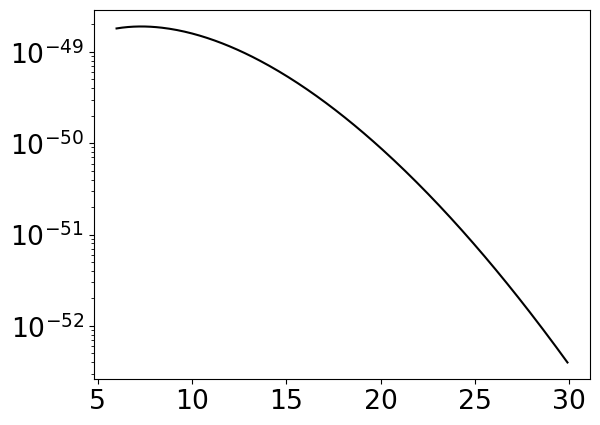

In [7]:
z = np.arange(6, 30, 0.1)
sfrd = pop_agg.get_sfrd(z)
plt.semilogy(z, sfrd, 'k-')

The spectrum of this source population is encoded in the `src` attribute -- an instance of another ARES class defined in `ares.sources`. The key method is `get_spectrum`:

# Loaded $ARES/bpass_v1/SEDS/sed.bpass.constant.nocont.sin.z004


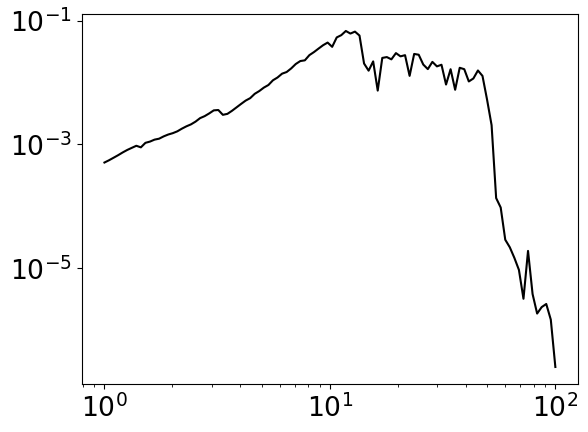

In [4]:
E = np.logspace(0, 2, 100)
plt.loglog(E, pop_agg.src.get_spectrum(E), 'k-')

Note that the `get_spectrum` method returns an SED normalized such that its integral in the `(EminNorm, EmaxNorm)` band is unity. The parameter `pop_radiative_yield` controls the total output in that same band, so that the product of `get_spectrum` and `pop_radiative_yield` gives the emissivity of the source population. To check for yourself:

In [5]:
from scipy.integrate import quad

quad(pop_agg.src.get_spectrum, pop_agg.pf['pop_EminNorm'], pop_agg.pf['pop_EmaxNorm'])

(0.0, 0.0)

And the total and specific emissivity...

NameError: name 'pop' is not defined

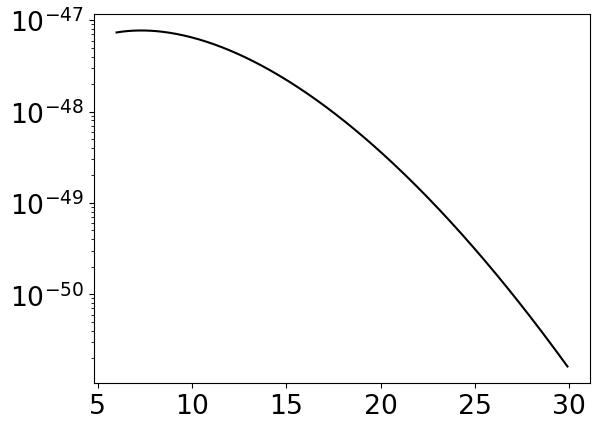

In [6]:
plt.semilogy(z, pop_agg.get_emissivity(z, E=200), 'k-')
plt.semilogy(z, pop_agg.get_sfrd(z) * pop.pf['pop_radiative_yield'], 'b--')

# The `GalaxyCohort` approach

Next, we'll explore models with mass-dependent galaxy properties. This was designed with the high-z Universe in mind ($z \gtrsim 4$) but can be generalized to model galaxies at any redshift. There are a few ways to do this:

1. By default, ARES assumes that the star formation rate of galaxies is proportional to the mass accretion rate of DM halos, 

\begin{equation}
\dot{M}_{\ast} = f_{\ast} \left(\frac{\Omega_{b,0}}{\Omega_{m,0}} \right) \dot{M}_h
\end{equation}

In principle one can integrate these star formation histories to obtain stellar masses self-consistently, but if interested only in rest-UV LFs, this is all you need. We'll discuss different models for $\dot{M}_h$ in a moment.

2. The MAR-based approach in #1 is well-suited to the high-z Universe, where we have models for the MAR that seem to work pretty well. However, to bypass this approach for applications at lower redshift (or just for fun), we can instead provide models for the stellar masses and star formation rates of galaxies separately.

## Models based on the mass accretion rate of DM halos

It is common to model the star formation efficiency of galaxies as a double power-law in halo mass, 

\begin{equation}
f_{\ast}(M_h) = \frac{2 f_{\ast,p}} {\left(\frac{M_h}{M_{\text{p}}} \right)^{\gamma_{\text{lo}}} + \left(\frac{M_h}{M_{\text{p}}}  \right)^{\gamma_{\text{hi}}}}
\end{equation}

where the free parameters are the normalization, $f_{\ast,p}$, the peak mass, $M_p$, and the power-law indices in the low-mass and high-mass limits, $\gamma_{\text{lo}}$ and $\gamma_{\text{hi}}$, respectively. Combined with a model for the mass accretion rate onto dark matter halos ($\dot{M}_h$; see next section), the star formation rate is fully specified.


In general, the SFE curve must be calibrated to an observational dataset (see [Fitting to UVLFs](example_mcmc_lf)), but you can also just grab our best-fitting parameters for a redshift-independent SFE curve. For example, the results from [Mirocha, Furlanetto, & Sun (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.464.1365M>) are kept in a ``ParameterBundle``:

In [ ]:
pars_m17 = ares.util.ParameterBundle('mirocha2017:base')
for par in pars_m17:
    print(par, pars_m17[par])

## Models based on the stellar-mass-halo-mass relation and star-forming main sequence

In [ ]:
pars_hod = \
{
 'pop_sfr_model': 'smhm-func',
 
 # SMHM parameters
 'pop_fstar': 'pq[0]',
 'pq_func[1]': 'dpl_evolN',
 'pq_func_par0[0]': 3e-4,
 'pq_func_par1[0]': 1.5e12,
 'pq_func_par2[0]': 1.0,
 'pq_func_par3[0]': -0.4,
 'pq_func_par6[0]': 0.0,   # norm
 'pq_func_par7[0]': 0.0,   # Mp
 'pq_func_par8[0]': 0.0,   # Only use if slopes evolve, e.g., in dplp_evolNPS
 'pq_func_par9[0]': 0.0,   # Only use if slopes evolve, e.g., in dplp_evolNPS

 # sSFR(z, Mstell)
 'pop_ssfr': 'pq[1]',
 'pq_func[1]': 'dpl_evolN',
 'pq_func_var[1]': 'Ms',
 'pq_func_var2[1]': '1+z',
 'pq_func_par0[1]': 3e-10,
 'pq_func_par1[1]': 5e9,
 'pq_func_par2[1]': 0.0,
 'pq_func_par3[1]': -0.7,
 'pq_func_par4[1]': 1e9,
 'pq_func_par5[1]': 1.,
 'pq_func_par6[1]': 2.,

 'final_redshift': 0, # Make this default?
 'halo_dt': None,
 'halo_tmax': None,
 'halo_zmin': 0,
 'cosmology_id': 'best',
 'cosmology_name': 'planck_TTTEEE_lowl_lowE',

}

pop_hod = ares.populations.GalaxyPopulation(**pars_hod)

# The `GalaxyEnsemble` approach
